In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Handling Missing Values
there are multiple strategies to handle missing values in our datasets. In our case (for categorical features) we have the following options:
- removing samples that have missing feature values
    - the problem with this approach is that it reduces the size of our dataset. The whole sample may get removed just because of one missing feature 
- impute the most frequent value
    - we are replacing the missing values with the most frequent value of that feature in the dataset. so the values will be biased towards the filled values
- treat the missing values as a separate feature value
    - this may add some false patterns and spurious correlations because the original dataset didn't have this value

For the general case, if the missing values are from numeric columns we have the following options:
- removing samples that have missing feature values
- replacing the missing values with the mean of the column
- replacing the missing values with the median of the column
- using regression to predict the missing values of each column based on the filled values
- ...

In [2]:
data = pd.read_csv("datasets/mushrooms.csv")
X_train, X_val_test, y_train, y_val_test = train_test_split(
    data.loc[:, data.columns != "class"], data["class"], train_size=0.7, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.33, random_state=42
)

in this case our method of choice is imputing the most frequent value


We have to be carefull not to apply most frequent imputation on the whole dataset before splitting. we want the train, test and validation datasets to be isolated as much as possible so that the most frequent value of our test set won't affect the training set.

In [3]:
imputer = SimpleImputer(strategy="most_frequent", missing_values="?")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

concatenated = pd.concat([X_train, X_val, X_test])
enc = OneHotEncoder().fit(concatenated)

# Desicion Tree

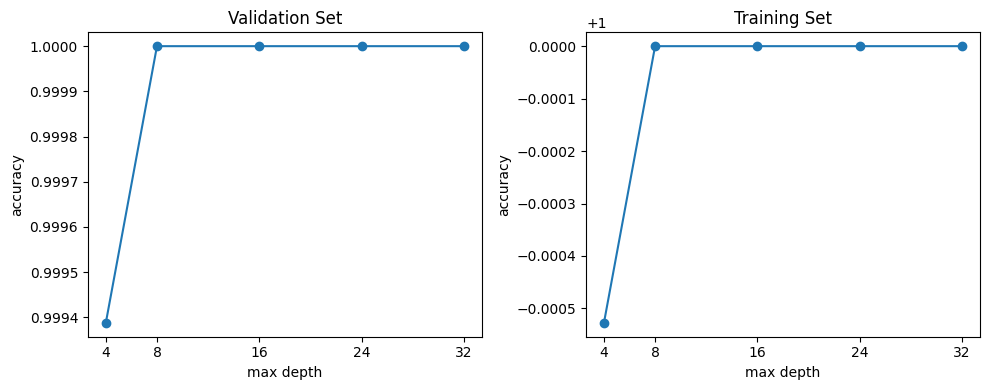

best model's max depth = 8
best model's accuracy on test data = 1.0


In [4]:
max_depths = (4, 8, 16, 24, 32)
acc_list_val, acc_list_train = [], []
best_acc = 0
for i in range(len(max_depths)):
    dt_cls_model = DecisionTreeClassifier(criterion="gini", max_depth=max_depths[i])
    dt_cls_model = dt_cls_model.fit(enc.transform(X_train), y_train)
    y_val_hat = dt_cls_model.predict(enc.transform(X_val))
    y_train_hat = dt_cls_model.predict(enc.transform(X_train))

    acc_list_val.append(sklearn.metrics.accuracy_score(y_val, y_val_hat))
    acc_list_train.append(sklearn.metrics.accuracy_score(y_train, y_train_hat))

    if acc_list_val[i] > best_acc:
        best_acc = acc_list_val[i]
        best_dt_cls_model = dt_cls_model
        best_max_depth = max_depths[i]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(max_depths, acc_list_val, marker="o")
axes[0].set_title("Validation Set")
axes[0].set_xlabel("max depth")
axes[0].set_ylabel("accuracy")
axes[0].set_xticks(max_depths)

axes[1].plot(max_depths, acc_list_train, marker="o")
axes[1].set_title("Training Set")
axes[1].set_xlabel("max depth")
axes[1].set_ylabel("accuracy")
axes[1].set_xticks(max_depths)

plt.tight_layout()
plt.show()

y_test_hat = best_dt_cls_model.predict(enc.transform(X_test))
acc_test = sklearn.metrics.accuracy_score(y_test, y_test_hat)
print(f"best model's max depth = {best_max_depth}")
print(f"best model's accuracy on test data = {acc_test}")

# Random Forest

In [6]:
def print_tabular(_dict):
    rows = sorted(set(key[0] for key in _dict))
    cols = sorted(set(key[1] for key in _dict))

    df = pd.DataFrame(
        index=["max depth = " + str(item) for item in rows],
        columns=["feature count = " + str(item) for item in cols],
    )
    for key, value in _dict.items():
        df.at["max depth = " + str(key[0]), "feature count = " + str(key[1])] = value

    display(df)


def select_random_features(X, feature_count):
    columns = list(X.columns)
    np.random.shuffle(columns)
    return columns[:feature_count]


max_depths = (4, 8, 12, 16)
feature_counts = (3, 5, 7)
acc_dict_val, acc_dict_train = {}, {}
best_model = {"acc": 0}
for md in max_depths:
    for fc in feature_counts:
        random_features = select_random_features(X_train, fc)
        enc2 = OneHotEncoder()
        enc2.fit(concatenated[random_features])

        rf_cls_model = RandomForestClassifier(
            n_estimators=7, criterion="gini", max_depth=md
        )
        rf_cls_model = rf_cls_model.fit(
            enc2.transform(X_train[random_features]), y_train
        )
        y_val_hat = rf_cls_model.predict(enc2.transform(X_val[random_features]))
        y_train_hat = rf_cls_model.predict(enc2.transform(X_train[random_features]))

        acc_val = sklearn.metrics.accuracy_score(y_val, y_val_hat)
        acc_train = sklearn.metrics.accuracy_score(y_train, y_train_hat)

        if acc_val > best_model["acc"]:
            best_model["acc"] = acc_val
            best_model["model"] = rf_cls_model
            best_model["max_depth"] = md
            best_model["feature_count"] = fc
            best_model["random_features"] = random_features
            best_model["encoder"] = enc2

        acc_dict_train[(md, fc)] = acc_train
        acc_dict_val[(md, fc)] = acc_val


print("accuracy on validation data:")
print_tabular(acc_dict_val)
print()
print("accuracy on training data:")
print_tabular(acc_dict_train)

y_test_hat = best_model["model"].predict(
    best_model["encoder"].transform(X_test[best_model["random_features"]])
)
acc_test = sklearn.metrics.accuracy_score(y_test, y_test_hat)
print(f"best model's max depth = {best_model['max_depth']}")
print(f"best model's feature count = {best_model['feature_count']}")
print(f"best model's accuracy on test data = {acc_test}")

accuracy on validation data:


,feature count = 3,feature count = 5,feature count = 7
max depth = 4,0.727495,0.829149,0.922229
max depth = 8,0.871402,0.993876,0.932639
max depth = 12,0.984691,0.935089,0.961421
max depth = 16,0.776485,0.995713,0.990814



accuracy on training data:


,feature count = 3,feature count = 5,feature count = 7
max depth = 4,0.727928,0.836089,0.914175
max depth = 8,0.874253,0.993141,0.933345
max depth = 12,0.986986,0.938797,0.965002
max depth = 16,0.776644,0.996483,0.994548


best model's max depth = 16
best model's feature count = 5
best model's accuracy on test data = 0.9937888198757764
